In [1]:
!pip3 install gymnasium[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 7.1 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# experience replay memory
## agent가 관찰하는 transition을 저장하므로 저장한 데이터를 재사용 가능
## 무작위로 샘플링하여 배치를 구성하는 transition과는 상관 없음
## DQN 학습을 크게 안정화하고 개선하는 것으로 알려짐

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
## state, action 쌍을 next_state, reward 결과에 매핑

class ReplayMemory(object):
## 관찰된 transition을 저장하는 제한된 크기의 cyclic buffer
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [4]:
# Q-network

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # 최적화 중에 next action을 결정하기 위해서 하나의 element 또는 batch를 이용해 호출
    # ([[left0exp,right0exp]...]) 반환
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [5]:
# 학습

## select_action : Epsilon-Greedy strategy에 따라 action 선택
### 임의의 action을 선택할 확률 : EPS_START에서 시작하여 EPS_END까지 지수적으로 감소
### EPS_DECAY : decay 속도 결정
## plot_durations : 이전 100개의 episode 평균에 따른 episode의 변화를 그림으로 그리기 위한 함수


BATCH_SIZE = 128 # 리플레이 버퍼에서 샘플링된 transition의 수
GAMMA = 0.99 # discount 계수
EPS_START = 0.9 # epsilon start 값
EPS_END = 0.05 # epsilon end 값
EPS_DECAY = 1000 # epsilon 감쇠 속도 결정, 높을수록 감쇠 속도 느림
TAU = 0.005 # 목표 네트워크의 업데이트 속도
LR = 1e-4 # optimizer learning rate

# gym action space 에서 action 개수 얻음
n_actions = env.action_space.n

# action observation 횟수를 얻습니다.
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
# amsgrad : AMSGrad 변형을 사용할지 여부
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    ## epsilon-greedy strategy 구현
    if sample > eps_threshold: # EXPLOITATION (착취)
        with torch.no_grad():
            # .max(1)은 각 행의 가장 큰 열 값 반환
            # 최대 결과의 두번째 열은 최대 요소의 주소값이므로,
            # 기대 보상이 더 큰 행동을 선택 가능
            return policy_net(state).max(1)[1].view(1, 1)
    else: # EXPLORATION (탐색)
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [7]:
# 학습 루프
## 배치 하나 샘플링 -> 모든 tensor 하나로 연결
## Q(s_t, a_t)와 V(s_{t+1})=max_aQ(s_{t+1}, a) 계산 후 loss 계산
## 정의에 따르면 s가 마지막 state일 경우 V(s) = 0

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (https://stackoverflow.com/a/19343/3343043)
    # batch-array의 Transitions을 Transition의 batch-arrays로 전환
    batch = Transition(*zip(*transitions))

    # 최종이 아닌 상태의 마스크(non_final_mask)를 계산하고 batch elements concat
    # (최종 상태 = 시뮬레이션이 종료 된 이후의 상태)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q(s_t, a) 계산 - 모델이 Q(s_t)를 계산하고, 취한 행동의 열을 선택
    # -> policy_net에 따라 각 배치 상태에 대해 선택된 행동
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 모든 next state를 위한 V(s_{t+1}) 계산
    # non_final_next_states의 행동들에 대한 기대값은 "이전" target_net을 기반으로 계산됩니다.
    # max(1)[0]으로 최고의 reward을 선택
    # 마스크를 기반으로 concat되어 expected state 값을 갖거나 state가 최종인 경우 0
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # expected Q 값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber 손실 계산
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    # 변화도 clipping 변경
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


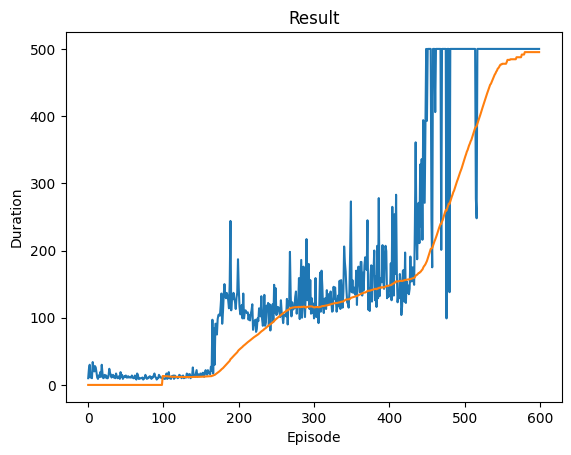

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
## 환경 재설정 & 초기 state Tensor 반환
## action 샘플링 -> 실행 -> next state, reward 관찰 -> 모델 최적화
## episode 끝나면 (=모델이 실패했으면) 학습 루프 다시 실행

## RL agent 학습 과정에는 노이즈가 많을 수 있기에
## 수렴이 관찰되지 않으면 -> 학습 다시 시작하는 것이 더 나은 결과 얻을 수 있는 방법

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # environment & state 초기화
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # 메모리에 transition 저장
        memory.push(state, action, next_state, reward)

        # 다음 state로 이동
        state = next_state

        # (policy 네트워크에서) 최적화 한단계 수행
        optimize_model()

        # 목표 네트워크의 가중치를 소프트 업데이트
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()